<a href="https://colab.research.google.com/github/J0SAL/Learning-DL/blob/main/codebasics/11.%20Bert/2.%20spam%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SPAM mail classification using BERT**

In [1]:
!pip install tensorflow-text

In [17]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

In [18]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [20]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

15% spam emails, 85% ham emails: This indicates class imbalance

performing undersampling


In [21]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [22]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [23]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [24]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [25]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [26]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
3010,spam,Update_Now - 12Mths Half Price Orange line ren...,1
807,ham,"sure, but make sure he knows we ain't smokin yet",0
4102,spam,GSOH? Good with SPAM the ladies?U could b a ma...,1
1209,ham,Also maaaan are you missing out,0
259,spam,We tried to contact you re your reply to our o...,1


**Split into train and test data**

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [28]:
X_train.head(4)

3169    Ugh hopefully the asus ppl dont randomly do a ...
2670    we tried to contact you re your response to ou...
4350          Ü bot notes oredi... Cos i juz rem i got...
4528    Understand. his loss is my gain :) so do you w...
Name: Message, dtype: object

**Importing BERT**

In [33]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

In [34]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences) # preprocessing
    return bert_encoder(preprocessed_text)['pooled_output'] #training

get_sentence_embeding(["500$ discount. hurry up",  "Bhavin, are you up for a volleybal game tomorrow?"])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132726 , -0.8884571 , ..., -0.7474883 ,
        -0.75314724,  0.91964495],
       [-0.8720837 , -0.50543964, -0.94446695, ..., -0.858475  ,
        -0.7174535 ,  0.88082975]], dtype=float32)>

**Get embeding vectors for few sample words. Compare them using cosine similarity**

In [35]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

**check similarity**

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [37]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703815]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [38]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872035]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

# Model Building  - Functional
Build Model
There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [39]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [41]:
len(X_train)

1120

In [42]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
] #doesn't affect to that extent

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

**Train the mode**

In [43]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 560s 15s/step - loss: 0.6786 - accuracy: 0.5830 - precision: 0.5754 - recall: 0.6339
Epoch 2/10
35/35 [==============================] - 501s 14s/step - loss: 0.5399 - accuracy: 0.7955 - precision: 0.8082 - recall: 0.7750
Epoch 3/10
35/35 [==============================] - 503s 14s/step - loss: 0.4556 - accuracy: 0.8607 - precision: 0.8582 - recall: 0.8643
Epoch 4/10
35/35 [==============================] - 505s 14s/step - loss: 0.4072 - accuracy: 0.8777 - precision: 0.8603 - recall: 0.9018
Epoch 5/10
35/35 [==============================] - 503s 14s/step - loss: 0.3803 - accuracy: 0.8768 - precision: 0.8651 - recall: 0.8929
Epoch 6/10
35/35 [==============================] - 503s 14s/step - loss: 0.3499 - accuracy: 0.8920 - precision: 0.8844 - recall: 0.9018
Epoch 7/10
35/35 [==============================] - 501s 14s/step - loss: 0.3409 - accuracy: 0.8821 - precision: 0.8591 - recall: 0.9143
Epoch 8/10
35/35 [=======================

In [44]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 168s 14s/step - loss: 0.2568 - accuracy: 0.9251 - precision: 0.9297 - recall: 0.9198


[0.2568197548389435, 0.9251337051391602, 0.929729700088501, 0.9197860956192017]

In [45]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [46]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,

In [47]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[174,  13],
       [ 15, 172]])

Text(33.0, 0.5, 'Truth')

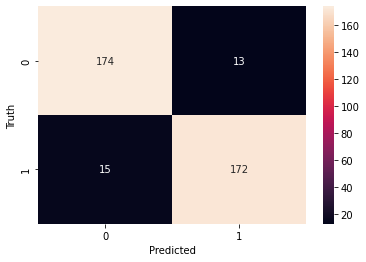

In [48]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [49]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       187
           1       0.93      0.92      0.92       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



**Inference**

In [50]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.72689694],
       [0.7866658 ],
       [0.7460905 ],
       [0.2018643 ],
       [0.10478225]], dtype=float32)

- 0.5< ~ 1 i.e spam

- 0.5> ~ 0 i.e not-spam